In [2]:
# Importer les bibliothèques nécessaires
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import morphology, measure
from scipy import ndimage

In [3]:
# Charger l'image BLOOD1.TIF en niveaux de gris
image = cv2.imread('BLOOD1.TIF', cv2.IMREAD_GRAYSCALE)
if image is None:
    print("Erreur : l'image 'BLOOD1.TIF' n'a pas pu être chargée.")
else:
    print("Image 'BLOOD1.TIF' chargée avec succès.")


Image 'BLOOD1.TIF' chargée avec succès.


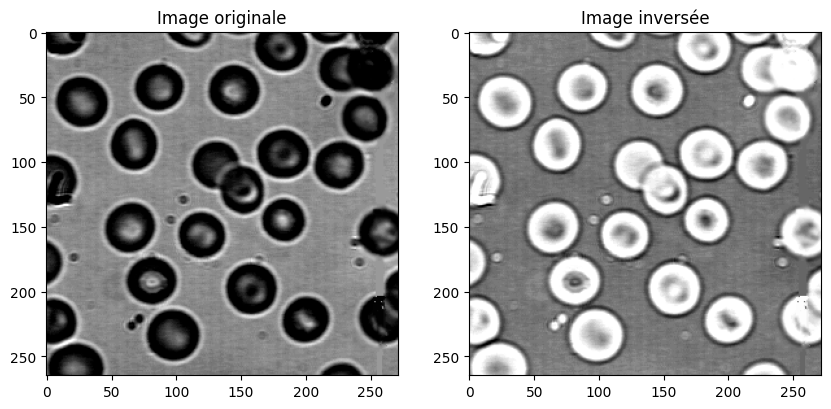

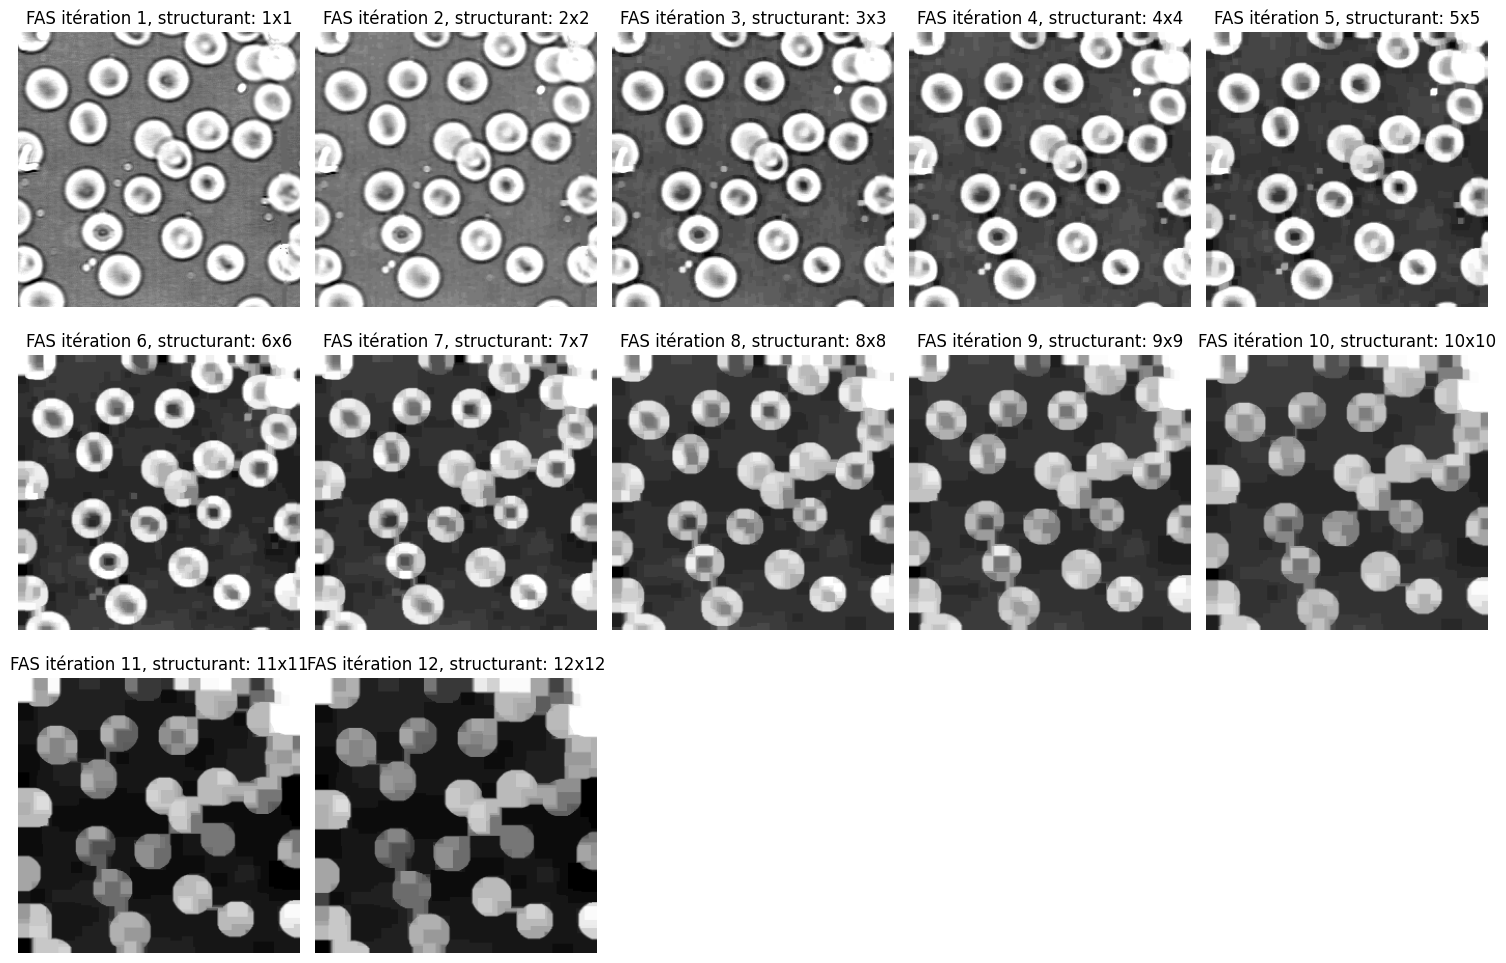

In [4]:
# Étape 1 : Inverser l'image pour que les cellules de sang soient en blanc
# et l'arrière-plan en noir
image_inv = cv2.bitwise_not(image)

# Afficher l'image originale et l'image inversée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Image originale")
plt.subplot(1, 2, 2)
plt.imshow(image_inv, cmap='gray')
plt.title("Image inversée")
plt.show()

# Fonction pour appliquer le filtre alterné séquentiel (FAS)
def filtre_alterne_sequentiel(image, initial_size=1, iterations=12):
    # Copie de l'image pour éviter de la modifier directement
    img_fas = image.copy()

    # Préparation de la figure pour les subplots
    plt.figure(figsize=(15, 10))
    rows = 3  # 3 lignes de subplots pour mieux visualiser
    cols = (iterations // rows) + 1

    for i in range(iterations):
        # Créer un élément structurant de taille croissante
        size = initial_size + i  # Incrémentation progressive de la taille
        structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))

        # Appliquer une ouverture puis une fermeture (FAS blanc)
        opened = cv2.morphologyEx(img_fas, cv2.MORPH_OPEN, structuring_element)
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, structuring_element)

        # Mettre à jour img_fas
        img_fas = closed

        # Afficher chaque itération dans un subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_fas, cmap='gray')
        plt.title(f"FAS itération {i+1}, structurant: {size}x{size}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img_fas

# Appliquer FAS sur l'image inversée
result_fas = filtre_alterne_sequentiel(image_inv)

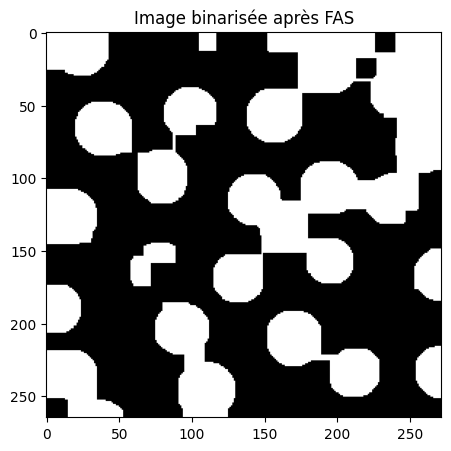

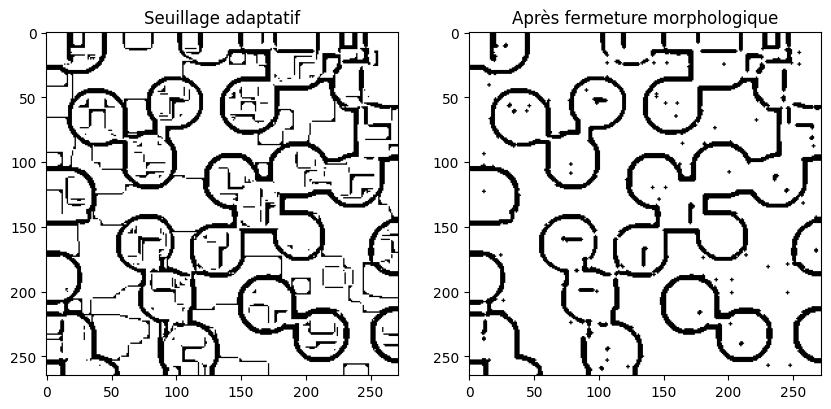

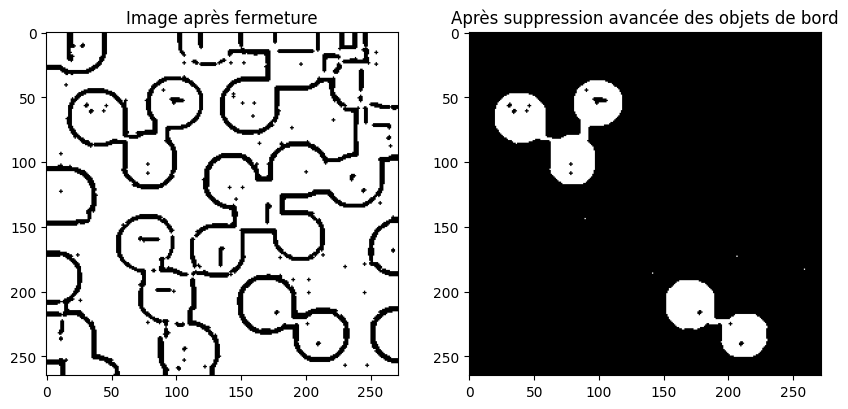

In [5]:
# Étape 2 : Suppression des objets touchant le bord

# Binariser l'image pour éviter les problèmes d'interférence de pixels
# Nous utilisons le seuillage d'Otsu pour créer une image binaire
_, image_binary = cv2.threshold(result_fas, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Nous utilisons le seuillage d'Otsu pour créer une image binaire
# + Utiliser un seuillage adaptatif pour garder les bords faibles
image_adaptive_thresh = cv2.adaptiveThreshold(
    result_fas, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 11, 2
)


# Afficher l'image binarisée
plt.figure(figsize=(10, 5))
plt.imshow(image_binary, cmap='gray')
plt.title("Image binarisée après FAS")
plt.show()


# Appliquer une fermeture morphologique pour lisser les formes des cellules
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
image_closed = cv2.morphologyEx(image_adaptive_thresh, cv2.MORPH_CLOSE, kernel)

# Afficher l'image après seuillage adaptatif et fermeture
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_adaptive_thresh, cmap='gray')
plt.title("Seuillage adaptatif")
plt.subplot(1, 2, 2)
plt.imshow(image_closed, cmap='gray')
plt.title("Après fermeture morphologique")
plt.show()



# Labeliser les objets connectés dans l'image après fermeture
labeled, num_labels = ndimage.label(image_closed)

# Créer un masque pour garder les objets sans connexion excessive aux bords
mask_border_objects = np.zeros_like(labeled)

# Définir la marge de bord pour vérifier les objets partiellement visibles aux bords
border_margin = 5

# Créer un masque représentant la zone de bord de 2 pixels de large
border_mask = np.zeros_like(labeled)
border_mask[:border_margin, :] = 1         # bord supérieur
border_mask[-border_margin:, :] = 1        # bord inférieur
border_mask[:, :border_margin] = 1         # bord gauche
border_mask[:, -border_margin:] = 1        # bord droit

# Parcourir chaque objet identifié dans l'image
for i in range(1, num_labels + 1):
    # Créer un masque temporaire pour chaque objet
    obj = (labeled == i)

    # Vérifier si l'objet touche le bord en utilisant le masque de bord
    if np.any(border_mask & obj):
        # Pour les objets qui touchent le bord mais sont très larges, on garde leur partie interne
        # Identifier les régions centrales pour les objets connectés aux bords
        distance_from_edge = ndimage.distance_transform_edt(~obj)

        # Seuil de distance pour définir la zone centrale (ajustable selon besoin)
        inner_mask = distance_from_edge > 10  # Garder seulement la partie interne

        # Ajouter la partie centrale au masque final
        mask_border_objects += obj & inner_mask
    else:
        # Si l'objet est complètement à l'intérieur, on l'ajoute au masque final
        mask_border_objects += obj

# Afficher l'image après suppression et traitement des objets de bord
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_closed, cmap='gray')
plt.title("Image après fermeture")
plt.subplot(1, 2, 2)
plt.imshow(mask_border_objects, cmap='gray')
plt.title("Après suppression avancée des objets de bord")
plt.show()

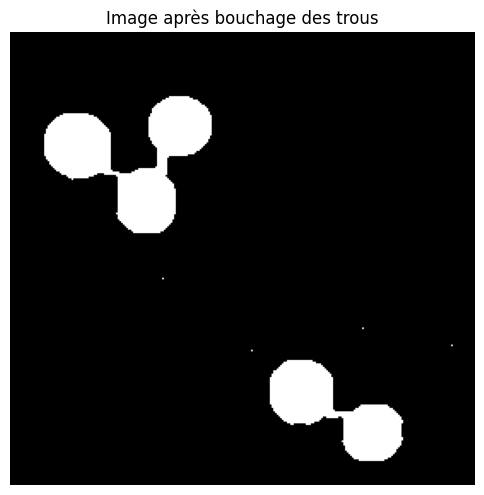

In [10]:
# Étape 3 : Bouchage des trous pour remplir les régions intérieures des cellules
# On utilise binary_fill_holes pour combler les trous à l'intérieur des cellules

# Appliquer le remplissage de trous pour conserver les cellules pleines
filled_image = ndimage.binary_fill_holes(mask_border_objects).astype(np.uint8) * 255

# Afficher l'image après l'opération de bouchage des trous
plt.figure(figsize=(6, 6))
plt.imshow(filled_image, cmap='gray')
plt.title("Image après bouchage des trous")
plt.axis("off")
plt.show()

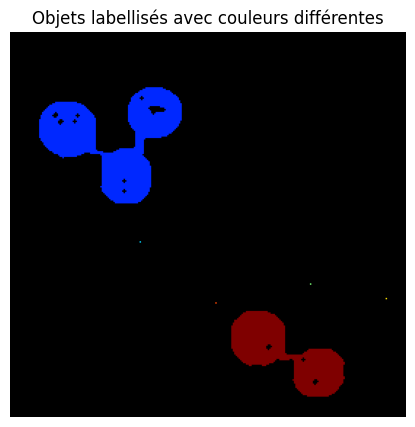

Nombre de cellules identifiées : 5


In [17]:
# Étape 4 : Labellisation des objets restants

# Labellisation pour donner un identifiant unique à chaque cellule de sang
labeled_image, num_features = ndimage.label(mask_border_objects)

# Créer une image colorée pour afficher les objets labellisés
# Utiliser un colormap pour colorer les labels de manière distincte
colored_labels = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)  # Image vide en couleur (RGB)

# Générer des couleurs distinctes pour chaque label
num_colors = num_features + 1  # +1 pour le fond
colors = plt.cm.jet(np.linspace(0, 1, num_colors))[:, :3] * 255  # Couleurs en RGB (0-255)

# Parcourir chaque label et assigner une couleur
for i in range(1, num_features + 1):
    colored_labels[labeled_image == i] = colors[i]

# Afficher l'image avec les objets labellisés colorés
plt.figure(figsize=(10, 5))
plt.imshow(colored_labels)
plt.title("Objets labellisés avec couleurs différentes")
plt.axis("off")
plt.show()

print(f"Nombre de cellules identifiées : {num_features - 1}")
